# Import cleaned dataset

In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display

df=pd.read_csv('~/code/fablaw/circor/raw_data/1.0.3/circor_dropped_modelConv1D.csv')
df

,Unnamed: 0,Patient ID,Recording locations:,Murmur,Murmur locations,Most audible location,Outcome
0,0,2530,AV+PV+TV+MV,Absent,NaN,NaN,1
1,1,9979,AV+PV+TV+MV,Present,AV+MV+PV+TV,TV,1
2,3,13918,AV+PV+TV+MV,Present,TV,TV,1
3,4,14241,AV+PV+TV+MV,Present,AV+MV+PV+TV,PV,1
4,5,14998,AV+PV+TV+MV,Absent,NaN,NaN,1
...,...,...,...,...,...,...,...
516,934,85337,AV+PV+TV+MV,Absent,NaN,NaN,0
517,935,85338,AV+PV+TV+MV,Absent,NaN,NaN,0
518,937,85340,AV+PV+TV+MV,Absent,NaN,NaN,0
519,938,85341,AV+PV+TV+MV,Absent,NaN,NaN,0


# Select random recordings for subjects w/o most audible location

In [2]:
ls=[]
for i in df.index:
    r=df.loc[i, 'Recording locations:'].split('+')
    l=np.random.choice(r)
    ls.append(l)

# Construct new dataframe

In [3]:
df_new=pd.DataFrame({'patient_id': df['Patient ID'], 
                     'select': ls,
                     'audible': df['Most audible location'],
                     'outcome': df.Outcome
                    })
df_new

,patient_id,select,audible,outcome
0,2530,TV,NaN,1
1,9979,PV,TV,1
2,13918,AV,TV,1
3,14241,PV,PV,1
4,14998,PV,NaN,1
...,...,...,...,...
516,85337,MV,NaN,0
517,85338,PV,NaN,0
518,85340,MV,NaN,0
519,85341,PV,NaN,0


# Fill audible column with random recordings for subjects w/o most audible rec

In [4]:
df_new.audible.fillna(df_new.select, inplace=True)
df_new

,patient_id,select,audible,outcome
0,2530,TV,TV,1
1,9979,PV,TV,1
2,13918,AV,TV,1
3,14241,PV,PV,1
4,14998,PV,PV,1
...,...,...,...,...
516,85337,MV,MV,0
517,85338,PV,PV,0
518,85340,MV,MV,0
519,85341,PV,PV,0


# Convert wav files to RGBA files

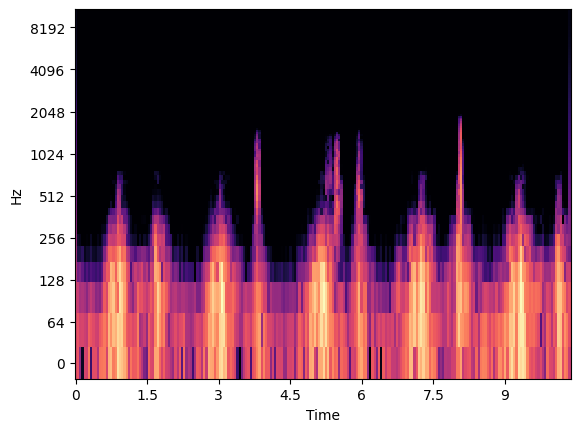

In [5]:
for i in df_new.index:
    file='../raw_data/1.0.3/audio_treated/'+str(df_new.loc[i, 'patient_id'])+'_'+df_new.loc[i,'audible']+'.wav'
    x, sr=librosa.load(file)
    
    D = librosa.stft(x[0:50000], n_fft=446, hop_length=224)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    
    spectrogram = librosa.display.specshow(S_db, y_axis="log", sr=sr, hop_length=1024, x_axis="time")
    
    rgbas= spectrogram.to_rgba(spectrogram.get_array().reshape(S_db.shape))
    
    rgba=rgbas[:,:,0:3]
    
    output='/Users/fabianlaw/code/fablaw/circor/raw_data/1.0.3/proc_img_treated/'+str(df_new.loc[i, 'patient_id'])+'_'+df_new.loc[i,'audible']+'.npy'
    np.save(output, rgba)

# Create X and y

In [6]:
X_raw=[]
for i in df_new.index:
    file='../raw_data/1.0.3/proc_img_treated/'+str(df_new.loc[i,'patient_id'])+'_'+df_new.loc[i,'audible']+'.npy'
    v=np.load(file)
    X_raw.append(v)
    
X=np.stack(X_raw)

In [7]:
X.shape

(521, 224, 224, 3)

In [8]:
y=df_new.outcome
y.shape

(521,)

# Create training set and testing set

In [9]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=1)

# Construct DL with transfer learning

In [10]:
from tensorflow.keras.layers import Dense, Flatten, MaxPool1D, Conv1D, LSTM, BatchNormalization, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.metrics import Recall

import matplotlib.pyplot as plt

In [11]:
base_model = DenseNet201(include_top=False, input_shape=(224, 224, 3))

In [12]:
base_model.trainable = False

In [13]:
layer1=Flatten()
layer2=Dense(2048, activation='relu')
layer3=Dense(1024, activation='relu')
layer4=Dense(512, activation='relu')
layer5=Dense(256, activation='relu')
layer6=Dense(128, activation='relu')
layer7=Dense(64, activation='relu')
layer8=Dense(32, activation='relu')
layer9=Dense(16, activation='relu')
layer10=Dense(8, activation='relu')
layer11=Dense(1, activation='sigmoid')

In [14]:
model = Sequential([base_model, layer1, layer2, layer3, layer4, layer5, layer6, layer7, layer8, layer9, layer10, layer11])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 94080)             0         
                                                                 
 dense (Dense)               (None, 2048)              192677888 
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               3

In [16]:
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy', Recall()])

# Testing model on training set with validation split

In [17]:
#es=EarlyStopping(patience=10, restore_best_weights=True, monitor='val_recall')
history=model.fit(X_train, y_train, 
                  validation_split=0.2, 
                  batch_size=32, 
                  epochs=30)

Epoch 1/30


/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]
2022-12-02 11:53:47.061574: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


10/10 [==============================] - 36s 3s/step - loss: 0.7023 - accuracy: 0.5670 - recall: 0.0000e+00 - val_loss: 0.7842 - val_accuracy: 0.4384 - val_recall: 0.0000e+00
Epoch 2/30
10/10 [==============================] - 24s 2s/step - loss: 0.7000 - accuracy: 0.5533 - recall: 0.2276 - val_loss: 0.8650 - val_accuracy: 0.4384 - val_recall: 0.0000e+00
Epoch 3/30
10/10 [==============================] - 26s 3s/step - loss: 0.6814 - accuracy: 0.5704 - recall: 0.3333 - val_loss: 0.8591 - val_accuracy: 0.4384 - val_recall: 0.0000e+00
Epoch 4/30
10/10 [==============================] - 29s 3s/step - loss: 0.6618 - accuracy: 0.6701 - recall: 0.2764 - val_loss: 0.7918 - val_accuracy: 0.4795 - val_recall: 0.0732
Epoch 5/30
10/10 [==============================] - 28s 3s/step - loss: 0.6340 - accuracy: 0.6460 - recall: 0.4309 - val_loss: 0.7429 - val_accuracy: 0.4932 - val_recall: 0.1220
Epoch 6/30
10/10 [==============================] - 26s 3s/step - loss: 0.6067 - accuracy: 0.6323 - recal

In [18]:
def plot_loss_recall(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=3)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    

    
    ax2.plot(history.history['recall'])
    ax2.plot(history.history['val_recall'])
    ax2.set_title('Recall')
    ax2.set_ylabel('Recall')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    plt.show()

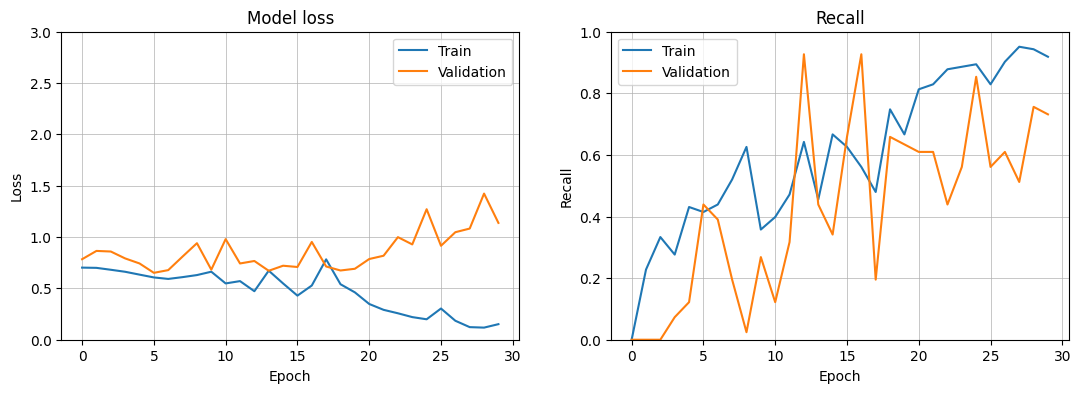

In [19]:
plot_loss_recall(history)

# Evaluation on testing set

In [20]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 7s 1s/step - loss: 1.3598 - accuracy: 0.4904 - recall: 0.6267


[1.3597791194915771, 0.4904458522796631, 0.6266666650772095]

In [21]:
filepath='~/code/fablaw/circor/raw_data/1.0.3/best_table.csv'
df_new.to_csv(filepath, index=False, header=True)